# Bayesian Assignment of State

In [29]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import warnings
import sys
sys.path.append("..")
import src.spc_utils.spc_os as spc_os
import pickle
import cellbell
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
from scipy.stats import halfcauchy, skewnorm, norm
from src.visualization.handle_data import combine_posterior_variables
from src.features.build_features import get_significant
#cpu or cuda
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float64'
import pymc3 as pm
RANDOM_SEED = 281090
warnings.filterwarnings("ignore")

In [3]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [4]:
%mkdir ../models/bayesian

mkdir: cannot create directory ‘../models/bayesian’: File exists


In [5]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

## Set-up parameters

In [7]:
method = 'shiftx2' # shiftx2 sparta_plus
nucleus = 'CA' #  N CA CB C
data_size = 2000 # 70000 max data_size
model_name = 'skew_model'
infer = False
critique = False
do_ppc = False

## Load and prepare data

Mask according to nuclei present in all 3 experimental states. Sample part of the data and select the nucleus.

In [8]:
df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')

In [9]:
mask = df_diff.dropna(axis=1).columns

In [10]:
df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [11]:
df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

In [12]:
df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [13]:
df_3fb5 = pd.read_pickle(processed_data_dir +
                         f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

In [14]:
df_3fb5 = df_3fb5.reindex(columns=mask).sample(data_size,
                                      random_state=RANDOM_SEED)
df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [15]:
df_5vk6 = pd.read_pickle(processed_data_dir +
                         f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

In [16]:
df_5vk6 = df_5vk6.reindex(columns=mask).sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [17]:
df_5vkh = pd.read_pickle(processed_data_dir +
                         f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

In [18]:
df_5vkh = df_5vkh.reindex(columns=mask).sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [19]:
coords = {
    'resid': [aa_dic[res] + str(res) for res in df_3fb5.columns],
    'step': df_3fb5.index
}

In [20]:
mask = df_3fb5.columns

In [21]:
df_diff = df_diff[mask]

In [22]:
df_exp_o = df_exp_o[mask]

## Study Data

Some notes on CA:
+ Fast exchange: 33,38, 71, 85, 107
+ One SU different: 61
+ Assymettrical subunits: 44, 51
+ Change during trajectory: 69
+ Homogeneous: Rest

Some notes on N:
+

### Time series

#### Closed

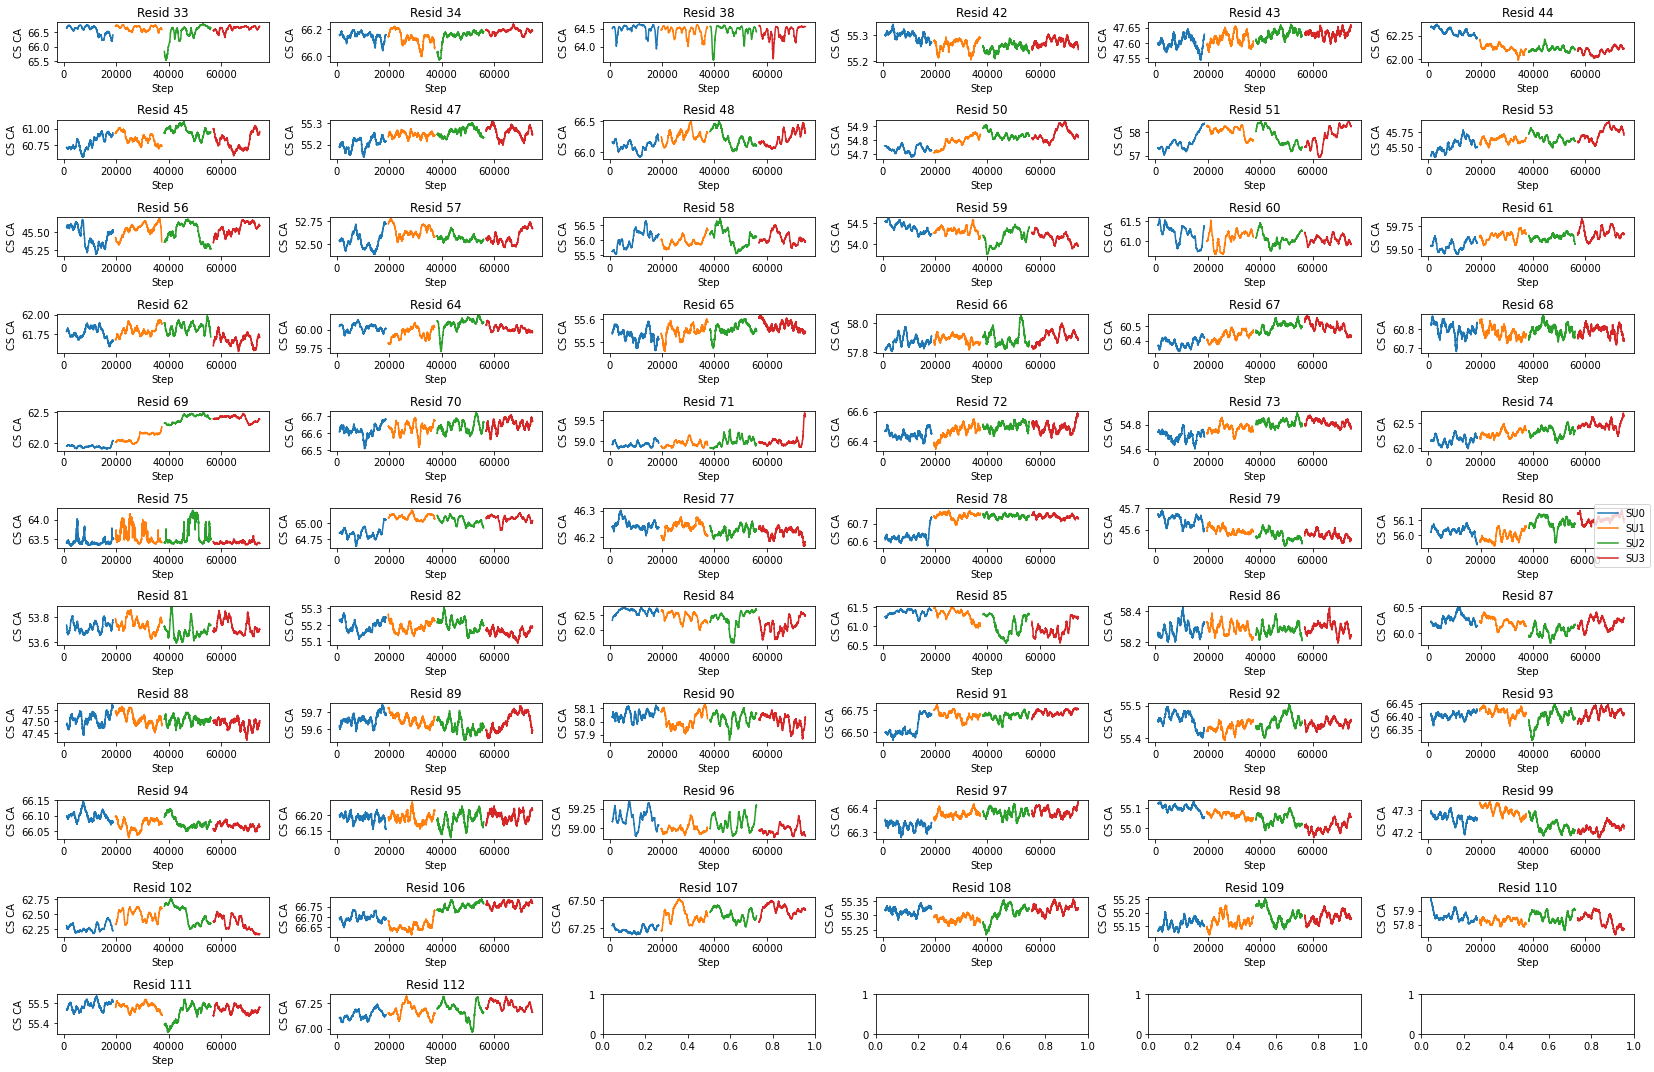

In [46]:
state = '5VKH_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Open

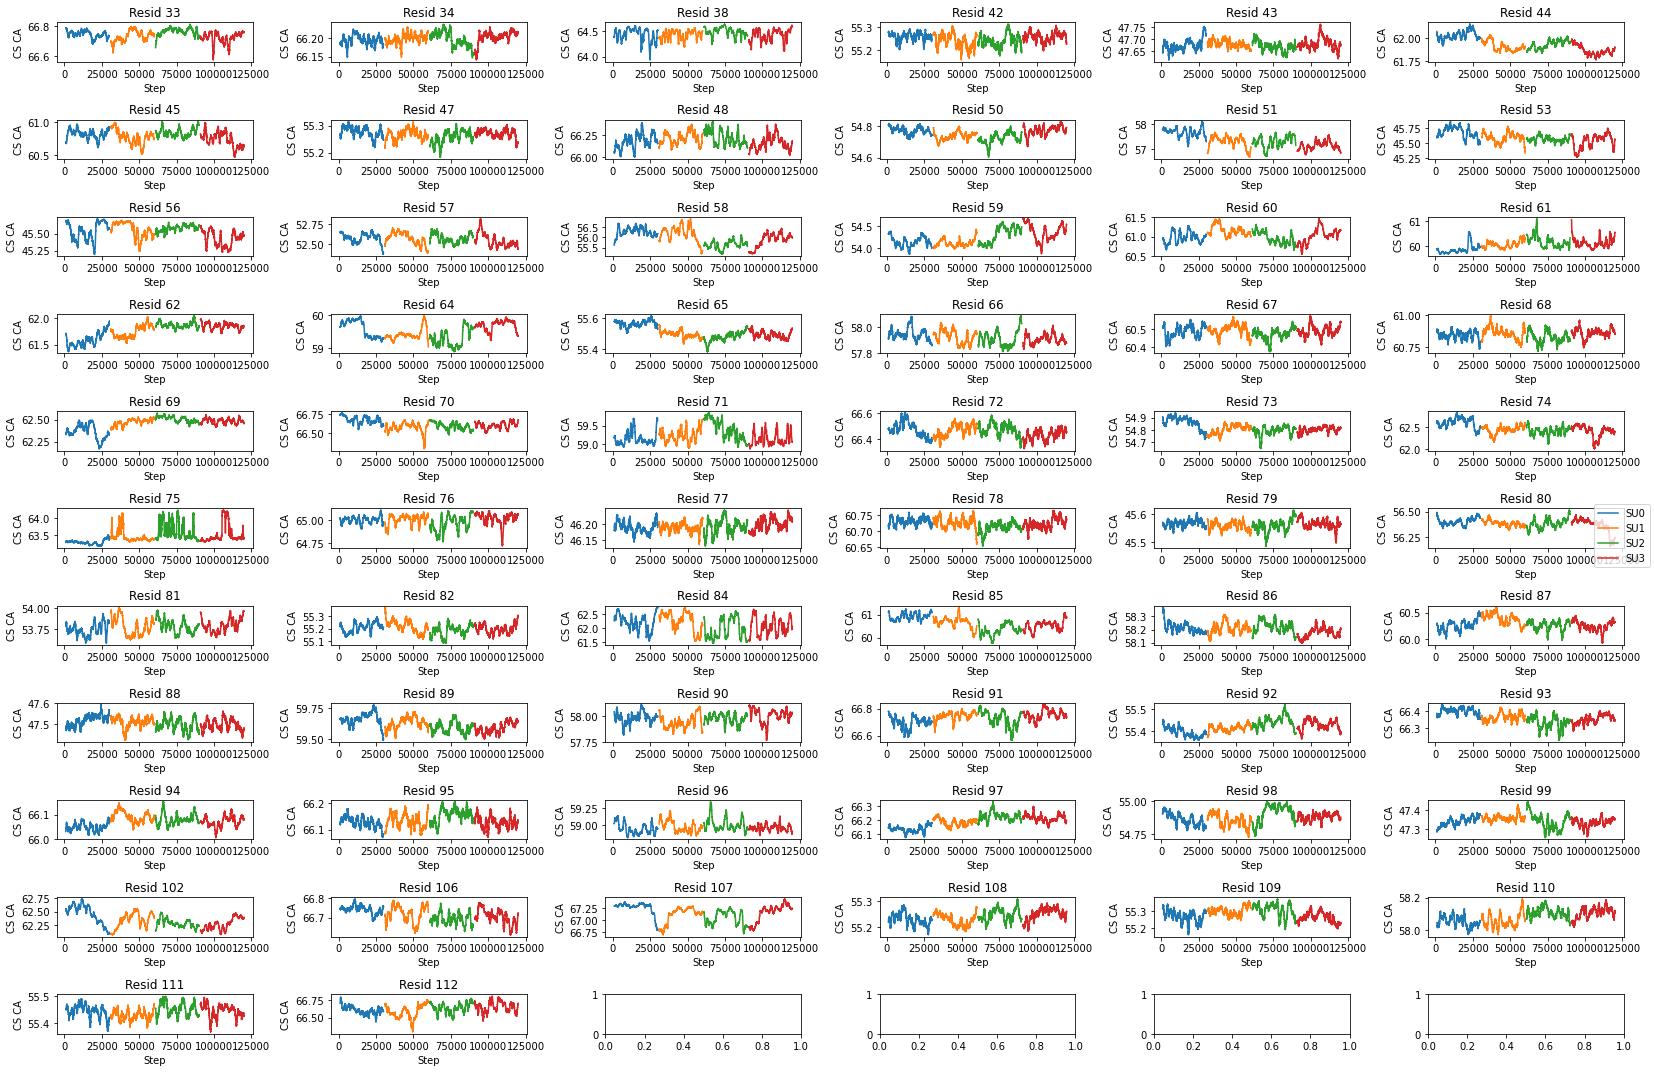

In [47]:
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Fully Open

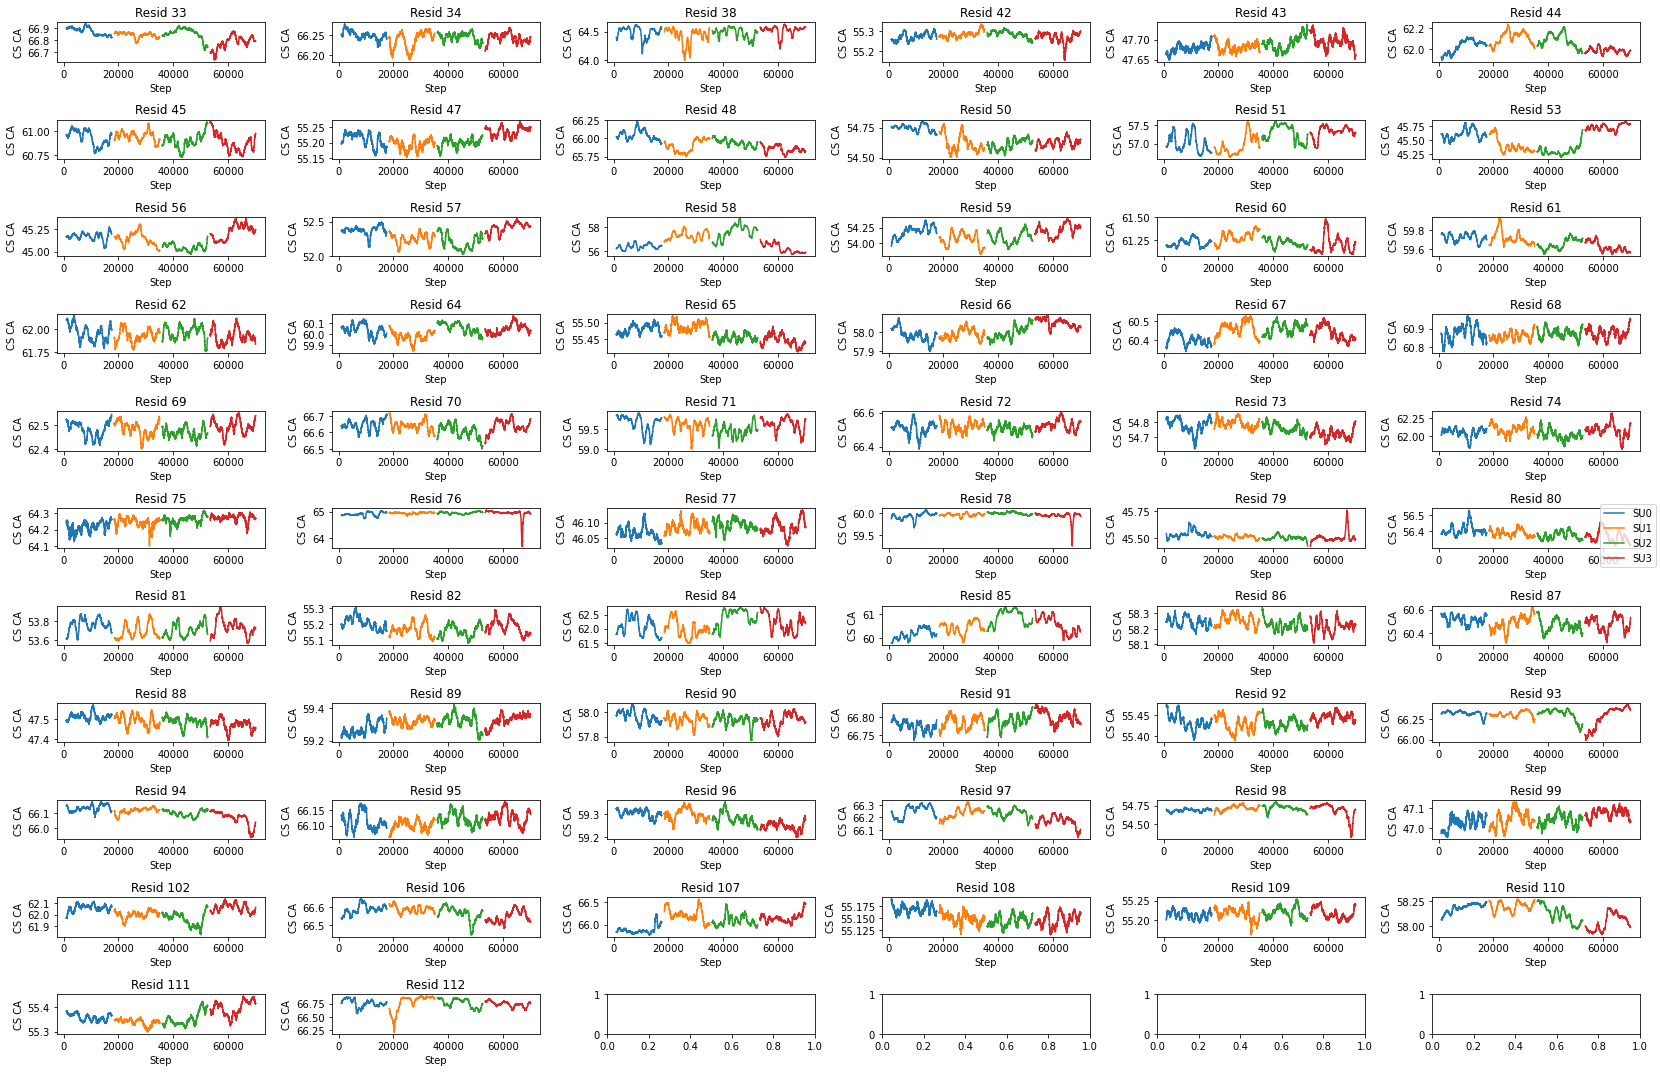

In [48]:
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

## Model Data

In [23]:
def skew_mean(mu, sig, alpha):
    mean = mu + sig * np.sqrt(2. / np.pi) * alpha / np.sqrt(1 + alpha * alpha)
    return mean

In [24]:
def skew_std(sig, alpha):
    std = np.sqrt(sig * sig * (1 - 2 * alpha * alpha / (alpha * alpha + 1) / np.pi))
    return std

In [25]:
if model_name == 'skew_model':
    beta_prior = 10
    alpha_prior = 10
    sd_prior = 10
    diff_vector = df_diff.to_numpy().reshape([df_diff.shape[1],])
    open_vector = df_exp_o.to_numpy().reshape([df_diff.shape[1],])
    with pm.Model(coords=coords) as my_model:
        mu_o = pm.Normal('mu_o', mu=df_3fb5.mean(), sd=sd_prior, dims='resid')
        sd_o = pm.HalfCauchy('sd_o', beta=beta_prior, dims='resid')
        alpha_o = pm.Normal('alpha_o', mu=0, sd=alpha_prior, dims='resid')
        mu_fo = pm.Normal('mu_fo', mu=df_5vk6.mean(), sd=sd_prior, dims='resid')
        sd_fo = pm.HalfCauchy('sd_fo', beta=beta_prior, dims='resid')
        alpha_fo = pm.Normal('alpha_fo', mu=0, sd=alpha_prior, dims='resid')
        mu_c = pm.Normal('mu_c', mu=df_5vkh.mean(), sd=sd_prior, dims='resid')
        sd_c = pm.HalfCauchy('sd_c', beta=beta_prior, dims='resid')
        alpha_c = pm.Normal('alpha_c', mu=0, sd=alpha_prior, dims='resid')

        # Define the likelihood.
        like_o = pm.SkewNormal('like_o',
                           mu=mu_o,
                           sd=sd_o,
                           alpha=alpha_o,
                           observed=df_3fb5,
                           dims=('step', 'resid')
                           )
        like_c = pm.SkewNormal('like_c',
                           mu=mu_c,
                           sd=sd_c,
                           alpha=alpha_c,
                           observed=df_5vkh,
                           dims=('step', 'resid')
                           )
        like_fo = pm.SkewNormal('like_fo',
                           mu=mu_fo,
                           sd=sd_fo,
                           alpha=alpha_fo,
                           observed=df_5vk6,
                           dims=('step', 'resid')
                           )
        mean_o = pm.Deterministic('mean_o', skew_mean(mu_o, sd_o, alpha_o), dims='resid')
        mean_fo = pm.Deterministic('mean_fo', skew_mean(mu_fo, sd_fo, alpha_fo), dims='resid')
        mean_c = pm.Deterministic('mean_c', skew_mean(mu_c, sd_c, alpha_c), dims='resid')
        std_o = skew_std(sd_o, alpha_o)
        std_fo = skew_std(sd_fo, alpha_fo)
        std_c = skew_std(sd_c, alpha_c)
        diff_means = pm.Deterministic('diff_means', mean_o - mean_fo, dims='resid')
        delta_o = pm.Deterministic('delta_o', mean_o - mean_c, dims='resid')
        delta_fo = pm.Deterministic('delta_fo', mean_fo - mean_c, dims='resid')
        mean_o_c = pm.Deterministic('mean_o_c', mean_o - mean_c - diff_vector, dims='resid')
        mean_fo_c = pm.Deterministic('mean_fo_c', mean_fo - mean_c - diff_vector, dims='resid')
        mean_o_c_abs = pm.Deterministic('mean_o_c_abs', np.abs(mean_o - mean_c - diff_vector), dims='resid')
        mean_fo_c_abs = pm.Deterministic('mean_fo_c_abs', np.abs(mean_fo - mean_c - diff_vector), dims='resid')
        mean_o_o = pm.Deterministic('mean_o_o', mean_o - open_vector, dims='resid')
        mean_fo_o = pm.Deterministic('mean_fo_o', mean_fo - open_vector, dims='resid')
        mean_o_o_abs = pm.Deterministic('mean_o_o_abs', np.abs(mean_o - open_vector), dims='resid')
        mean_fo_o_abs = pm.Deterministic('mean_fo_o_abs', np.abs(mean_fo - open_vector), dims='resid') 
        pooled_sd = np.sqrt(np.power(std_o, 2) + np.power(std_fo, 2) / (2))
        effect_size = pm.Deterministic('effect_size',
                                       diff_means / pooled_sd, dims='resid')
    model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"

In [26]:
%%time
%%ding
if infer:
    with my_model:
        my_model_trace = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=False)
        ppc = pm.sample_posterior_predictive(my_model_trace, var_names=["like_fo","like_o","like_c"], random_seed=RANDOM_SEED)
    my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)
    print('Done infering.')
    spc_os.remove(model_path)
    my_model_trace.to_netcdf(model_path)
    print('Done saving.')
    del ppc

CPU times: user 331 ms, sys: 249 ms, total: 580 ms
Wall time: 4.62 s


## Critize model 

In [27]:
my_model_trace = az.from_netcdf(model_path)

In [30]:
spc_os.mkdir(reports_dir + f'critique/{model_name}_{method}_{nucleus}')

In [31]:
my_model_trace.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000, resid: 62, step: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * step     (step) int64 49160 23055 66022 61694 ... 5963 11166 11954 64500
  * resid    (resid) object 'T33' 'V34' 'I38' 'A42' ... 'L110' 'A111' 'T112'
Data variables:
    like_fo  (chain, draw, step, resid) float64 ...
    like_o   (chain, draw, step, resid) float64 ...
    like_c   (chain, draw, step, resid) float64 ...
Attributes:
    created_at:                 2020-11-19T18:40:22.692548
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.9.3

In [32]:
my_model_trace.posterior_predictive.like_o.shape

(4, 2000, 2000, 62)

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [30]:
if critique:
    df_summary = az.summary(my_model_trace)
    with pd.option_context('display.max_rows', None):
        print(df_summary)

### Plot Traces (Posteriors)

In [32]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [33]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [34]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [35]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [36]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [37]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [38]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [39]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [40]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

### Autocorrelations

In [41]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [42]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [43]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [44]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [45]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [46]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [47]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [48]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [49]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

### Posterior Predictive Test

### PPC Closed

In [51]:
if do_ppc:
    state = 'fo'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Fully Open

In [51]:
if do_ppc:
    state = 'o'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Open

In [52]:
if do_ppc:
    state = 'c'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

## Investigate

In [53]:
my_model = az.from_netcdf(model_path)

In [54]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [55]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [56]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['alpha_o', 'alpha_fo', 'alpha_c'], 'alpha', 'state',
    ['o', 'fo', 'c'])

In [57]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'mean_ref', 'state',
    ['o', 'fo'])

In [58]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o', 'mean_fo', 'mean_c'], 'mean', 'state',
    ['o', 'fo', 'c'])

### Is it Skewed?

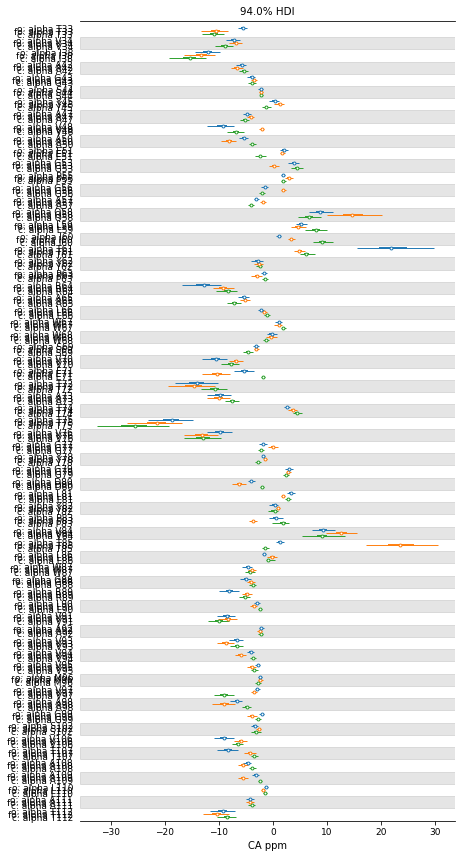

In [59]:
%%ding
variable = 'alpha'
az.plot_forest((my_model.sel(state="o"), 
                my_model.sel(state="fo"),
                my_model.sel(state="c")),
               var_names=variable,
               combined=True,
               colors=["C0", "C1","C2"],
               model_names=["o", "fo","c"],
               textsize=9,
               figsize=(7, 15))
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/{variable}_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()